In [1]:
# Imports
from __future__ import division
import numpy as np
import os
import glob
from PIL import Image
from random import *
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
get_ipython().magic(u'matplotlib inline')

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Activation, BatchNormalization
from keras.layers.convolutional import Convolution2D, Cropping2D, ZeroPadding2D, MaxPooling2D
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle

Using TensorFlow backend.


In [2]:
# Create sentence writer mapping
#Dictionary with form and writer mapping
d = {}
with open('forms_for_parsing.txt') as f:
    for line in f:
        l = line.split(' ')
        writer = l[1]
        d[l[0]] = writer

In [4]:
# Create array of file names and corresponding target writer names
tmp = []
target_list = []
path_to_files = os.path.join('data_subset', '*')
for filename in sorted(glob.glob(path_to_files)):
    tmp.append(filename)
    image_name = filename.split('/')[-1]
    file, ext = os.path.splitext(image_name)
    parts = file.split('-')
    form = parts[0] + '-' + parts[1]
    for key in d:
        if key == form:
            target_list.append(str(d[form]))

img_files = np.asarray(tmp)
img_targets = np.asarray(target_list)

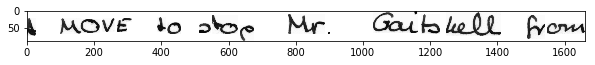

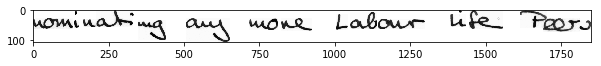

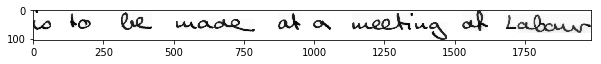

In [5]:
# Visualizing the data
for filename in img_files[:3]:
    img=mpimg.imread(filename)
    plt.figure(figsize=(10,10))
    plt.imshow(img, cmap ='gray')

In [6]:
# Label Encode writer names for one hot encoding later
encoder = LabelEncoder()
encoder.fit(img_targets)
encoded_Y = encoder.transform(img_targets)

print(img_files[:5], img_targets[:5], encoded_Y[:5])

['data_subset/a01-000u-s00-00.png' 'data_subset/a01-000u-s00-01.png'
 'data_subset/a01-000u-s00-02.png' 'data_subset/a01-000u-s00-03.png'
 'data_subset/a01-000u-s01-00.png'] ['000' '000' '000' '000' '000'] [0 0 0 0 0]


In [7]:
#split into test train and validation in ratio 4:1:1

from sklearn.model_selection import train_test_split
train_files, rem_files, train_targets, rem_targets = train_test_split(
        img_files, encoded_Y, train_size=0.66, random_state=52, shuffle= True)

validation_files, test_files, validation_targets, test_targets = train_test_split(
        rem_files, rem_targets, train_size=0.5, random_state=22, shuffle=True)

print(train_files.shape, validation_files.shape, test_files.shape)
print(train_targets.shape, validation_targets.shape, test_targets.shape)

(3233,) (833,) (833,)
(3233,) (833,) (833,)


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [8]:
# Generator function for generating random crops from each sentence

# Now create generators for randomly cropping 113x113 patches from these images

batch_size = 16
num_classes = 50

def generate_data(samples, target_files,  batch_size=batch_size, factor = 0.1 ):
    num_samples = len(samples)
    while (True):
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            batch_targets = target_files[offset:offset+batch_size]

            images = []
            targets = []
            for i in range(len(batch_samples)):
                batch_target = batch_targets[i]
                im = Image.open(batch_samples[i])
                height_fac = 113 / im.size[1]

                new_width = int(im.size[0] * height_fac)
                size = new_width, 113

                imresize = im.resize((size), Image.ANTIALIAS)
                avail_x_points = list(range(0, imresize.size[0] - 113 ))
                pick_num = int(len(avail_x_points)*factor)
                random_startx = sample(avail_x_points,  pick_num)

                for start in random_startx:
                    imcrop = imresize.crop((start, 0, start+113, 113))
                    images.append(np.asarray(imcrop))
                    targets.append(batch_target)

            X_train = np.array(images)
            y_train = np.array(targets)

            X_train = X_train.reshape(X_train.shape[0], 113, 113, 1)
            X_train = X_train.astype('float32')
            X_train /= 255

            y_train = to_categorical(y_train, num_classes)

            yield shuffle(X_train, y_train)

In [9]:
# Generate data for training and validation
train_generator = generate_data(train_files, train_targets, batch_size=batch_size, factor = 0.3)
validation_generator = generate_data(validation_files, validation_targets, batch_size=batch_size, factor = 0.3)
test_generator = generate_data(test_files, test_targets, batch_size=batch_size, factor = 0.1)

In [10]:
# Build a neural network in Keras

def resize_image(image):
    import tensorflow as tf
    return tf.image.resize_images(image,[56,56])

row, col, ch = 113, 113, 1

model = Sequential()
model.add(ZeroPadding2D((1, 1), input_shape=(row, col, ch)))

model.add(Lambda(resize_image))  

model.add(Convolution2D(filters= 32, kernel_size =(5,5), strides= (2,2), padding='same', name='conv1')) #96
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool1'))

model.add(Convolution2D(filters= 64, kernel_size =(3,3), strides= (1,1), padding='same', name='conv2'))  #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool2'))

model.add(Convolution2D(filters= 128, kernel_size =(3,3), strides= (1,1), padding='same', name='conv3'))  #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool3'))


model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(512, name='dense1'))  
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256, name='dense2'))  
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes,name='output'))
model.add(Activation('softmax'))  

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 115, 115, 1)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 56, 56, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 32)        832       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 64)        0         
__________

In [3]:
# Train the model 

nb_epoch = 8

samples_per_epoch = 3268
nb_val_samples = 842


from keras.callbacks import ModelCheckpoint
filepath="checkpoint2/check-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath= filepath, verbose=1, save_best_only=False)
callbacks_list = [checkpoint]

history_object = model.fit_generator(train_generator, samples_per_epoch= samples_per_epoch,
                                     validation_data=validation_generator,
                                     nb_val_samples=nb_val_samples, nb_epoch=nb_epoch, verbose=1, callbacks=callbacks_list)

In [2]:
# Load save model and use for prediction on test set
model.load_weights('low_loss.hdf5')
scores = model.evaluate_generator(test_generator,842) 
print("Accuracy = ", scores[1])

Accuracy = 0.988
